In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import itertools

import scipy.stats

import numpy as np

import seaborn as sns

import tqdm.autonotebook as tqdm

C:\Users\nahod\AppData\Local\Temp/ipykernel_22300/2535157637.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [3]:
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

C:\Users\nahod\AppData\Local\Temp/ipykernel_22300/3203818461.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [5]:
def ewma_vectorized(data, alpha, offset=None, dtype=None, order='C', out=None):
    """
    Calculates the exponential moving average over a vector.
    Will fail for large inputs.
    :param data: Input data
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param offset: optional
        The offset for the moving average, scalar. Defaults to data[0].
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Defaults to 'C'.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the input. If not provided or `None`,
        a freshly-allocated array is returned.
    """
    data = np.array(data, copy=False)

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float64
    else:
        dtype = np.dtype(dtype)

    if data.ndim > 1:
        # flatten input
        data = data.reshape(-1, order)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    if data.size < 1:
        # empty input, return empty array
        return out

    if offset is None:
        offset = data[0]

    alpha = np.array(alpha, copy=False).astype(dtype, copy=False)

    # scaling_factors -> 0 as len(data) gets large
    # this leads to divide-by-zeros below
    scaling_factors = np.power(1. - alpha, np.arange(data.size + 1, dtype=dtype),
                               dtype=dtype)
    # create cumulative sum array
    np.multiply(data, (alpha * scaling_factors[-2]) / scaling_factors[:-1],
                dtype=dtype, out=out)
    np.cumsum(out, dtype=dtype, out=out)

    # cumsums / scaling
    out /= scaling_factors[-2::-1]

    if offset != 0:
        offset = np.array(offset, copy=False).astype(dtype, copy=False)
        # add offsets
        out += offset * scaling_factors[1:]

    return out

In [6]:
n_dots = 1000
a_s, b_s = [1, 3, 6], [-10, 1, 10]

xs, ys = [], []
for a, b in zip(a_s, b_s):
    x = np.linspace(1, 100, n_dots)
    y = (
        (b + np.random.normal(0.0, 2, n_dots)) * np.power(x, a + np.random.normal(0.0, 0.1, n_dots)) + 
        np.random.normal(0.0, 1, n_dots)
    )
    xs.append(x)
    ys.append(y)

# Неплохой график

C:\Users\nahod\AppData\Local\Temp/ipykernel_22300/551213388.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


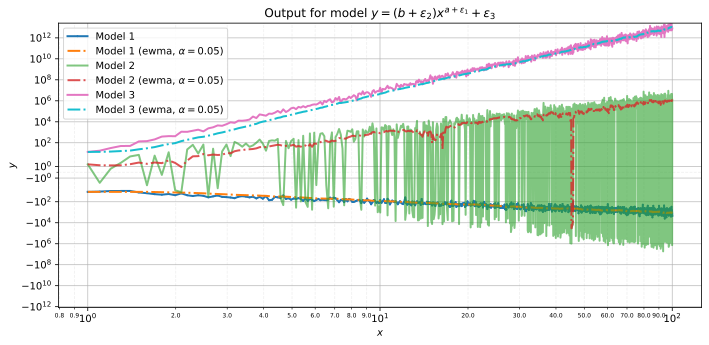

In [7]:
set_matplotlib_formats('pdf', 'svg')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

cmap = plt.get_cmap('tab10')
ax.plot(
    xs[0], ys[0], label='Model 1', marker='o', markersize=1,
    linestyle='-', linewidth=2, alpha=1.0, color=cmap(0)
)
ax.plot(
    xs[0], ewma_vectorized(ys[0], alpha=0.05), label=r'Model 1 (ewma, $\alpha=0.05$)', 
    linestyle='-.', linewidth=2, alpha=1.0, color=cmap(1)
)
ax.plot(
    xs[1], ys[1], label='Model 2', 
    linestyle='-', linewidth=2, alpha=0.6, color=cmap(2)
)
ax.plot(
    xs[1], ewma_vectorized(ys[1], alpha=0.05), label=r'Model 2 (ewma, $\alpha=0.05$)',
    linestyle='-.', linewidth=2, alpha=0.8, color=cmap(3)
)
ax.plot(
    xs[2], ys[2], label='Model 3',
    linestyle='-', linewidth=2, alpha=1.0, color=cmap(6)
)
ax.plot(
    xs[2], ewma_vectorized(ys[2], alpha=0.05), label=r'Model 3 (ewma, $\alpha=0.05$)',
    linestyle='-.', linewidth=2, alpha=1.0, color=cmap(9)
)
ax.grid(which='major', alpha=0.8)
ax.grid(which='minor', alpha=0.2, linestyle='--')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('symlog')


yticks = np.concatenate([-np.power(10, -np.arange(-12, 1.)), [0], np.power(10, np.arange(0, 13.))])
yticklabels = (
    ['$-10^{' + f'{idx}' + '}$' for idx in -np.arange(-12, 1)] + 
    [''] + 
    ['$10^{' + f'{idx}' + '}$' for idx in np.arange(0, 13)]
)
ax.set_yticks(yticks[::2])
ax.set_yticklabels(yticklabels[::2])

ax.xaxis.set_minor_formatter(ticker.FormatStrFormatter("%.1f"))
ax.tick_params(axis='both', which='minor', labelsize=6)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Output for model $y = (b + \epsilon_{2})x^{a + \epsilon_{1}} + \epsilon_{3}$')

fig.tight_layout()
plt.show()
fig.savefig('./Figures/bad_plots/good_plot.pdf')

# Не векторный

C:\Users\nahod\AppData\Local\Temp/ipykernel_22300/4212929444.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


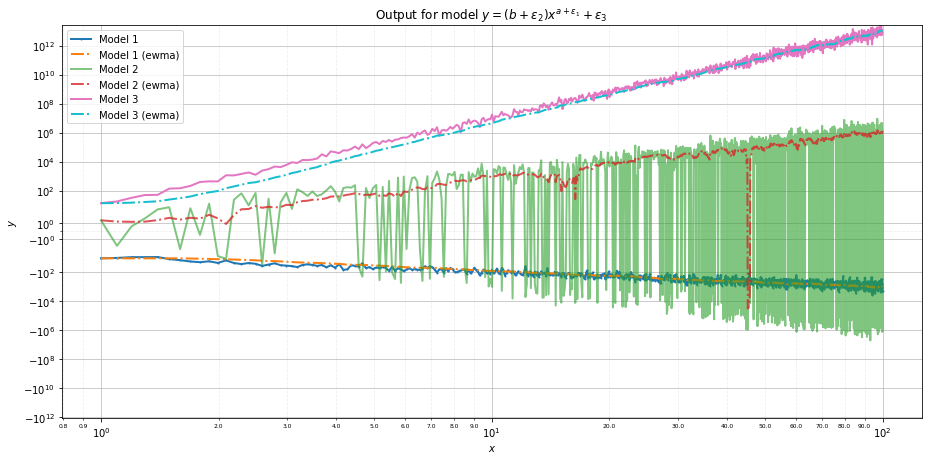

In [8]:
set_matplotlib_formats('png')

fig, ax = plt.subplots(1, 1, figsize=(13, 6.5))

cmap = plt.get_cmap('tab10')
ax.plot(
    xs[0], ys[0], label='Model 1', marker='o', markersize=1,
    linestyle='-', linewidth=2, alpha=1.0, color=cmap(0)
)
ax.plot(
    xs[0], ewma_vectorized(ys[0], alpha=0.05), label='Model 1 (ewma)',
    linestyle='-.', linewidth=2, alpha=1.0, color=cmap(1)
)
ax.plot(
    xs[1], ys[1], label='Model 2', 
    linestyle='-', linewidth=2, alpha=0.6, color=cmap(2)
)
ax.plot(
    xs[1], ewma_vectorized(ys[1], alpha=0.05), label='Model 2 (ewma)',
    linestyle='-.', linewidth=2, alpha=0.8, color=cmap(3)
)
ax.plot(
    xs[2], ys[2], label='Model 3',
    linestyle='-', linewidth=2, alpha=1.0, color=cmap(6)
)
ax.plot(
    xs[2], ewma_vectorized(ys[2], alpha=0.05), label='Model 3 (ewma)',
    linestyle='-.', linewidth=2, alpha=1.0, color=cmap(9)
)
ax.grid(which='major', alpha=0.8)
ax.grid(which='minor', alpha=0.2, linestyle='--')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('symlog')


yticks = np.concatenate([-np.power(10, -np.arange(-12, 1.)), [0], np.power(10, np.arange(0, 13.))])
yticklabels = (
    ['$-10^{' + f'{idx}' + '}$' for idx in -np.arange(-12, 1)] + 
    [''] + 
    ['$10^{' + f'{idx}' + '}$' for idx in np.arange(0, 13)]
)
ax.set_yticks(yticks[::2])
ax.set_yticklabels(yticklabels[::2])

ax.xaxis.set_minor_formatter(ticker.FormatStrFormatter("%.1f"))
ax.tick_params(axis='both', which='minor', labelsize=6)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Output for model $y = (b + \epsilon_{2})x^{a + \epsilon_{1}} + \epsilon_{3}$')

fig.tight_layout()
plt.show()
fig.savefig('./Figures/bad_plots/non_vector_plot.png')

# Без сетки

C:\Users\nahod\AppData\Local\Temp/ipykernel_22300/2482318422.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


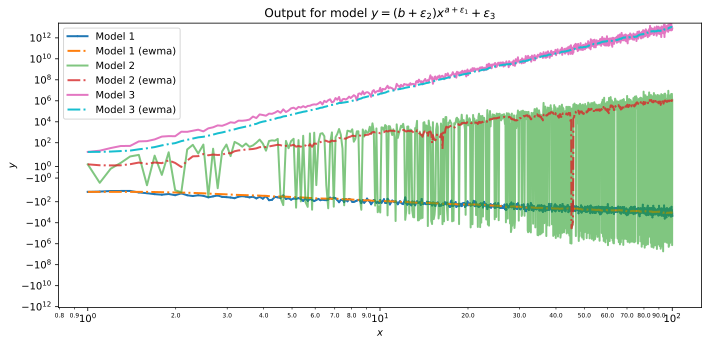

In [9]:
set_matplotlib_formats('pdf', 'svg')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

cmap = plt.get_cmap('tab10')
ax.plot(
    xs[0], ys[0], label='Model 1', marker='o', markersize=1,
    linestyle='-', linewidth=2, alpha=1.0, color=cmap(0)
)
ax.plot(
    xs[0], ewma_vectorized(ys[0], alpha=0.05), label='Model 1 (ewma)',
    linestyle='-.', linewidth=2, alpha=1.0, color=cmap(1)
)
ax.plot(
    xs[1], ys[1], label='Model 2', 
    linestyle='-', linewidth=2, alpha=0.6, color=cmap(2)
)
ax.plot(
    xs[1], ewma_vectorized(ys[1], alpha=0.05), label='Model 2 (ewma)',
    linestyle='-.', linewidth=2, alpha=0.8, color=cmap(3)
)
ax.plot(
    xs[2], ys[2], label='Model 3',
    linestyle='-', linewidth=2, alpha=1.0, color=cmap(6)
)
ax.plot(
    xs[2], ewma_vectorized(ys[2], alpha=0.05), label='Model 3 (ewma)',
    linestyle='-.', linewidth=2, alpha=1.0, color=cmap(9)
)

ax.legend()
ax.set_xscale('log')
ax.set_yscale('symlog')


yticks = np.concatenate([-np.power(10, -np.arange(-12, 1.)), [0], np.power(10, np.arange(0, 13.))])
yticklabels = (
    ['$-10^{' + f'{idx}' + '}$' for idx in -np.arange(-12, 1)] + 
    [''] + 
    ['$10^{' + f'{idx}' + '}$' for idx in np.arange(0, 13)]
)
ax.set_yticks(yticks[::2])
ax.set_yticklabels(yticklabels[::2])

ax.xaxis.set_minor_formatter(ticker.FormatStrFormatter("%.1f"))
ax.tick_params(axis='both', which='minor', labelsize=6)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Output for model $y = (b + \epsilon_{2})x^{a + \epsilon_{1}} + \epsilon_{3}$')

fig.tight_layout()
plt.show()
fig.savefig('./Figures/bad_plots/no_grid_plot.pdf')

# Без подписей

C:\Users\nahod\AppData\Local\Temp/ipykernel_22300/4084363963.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


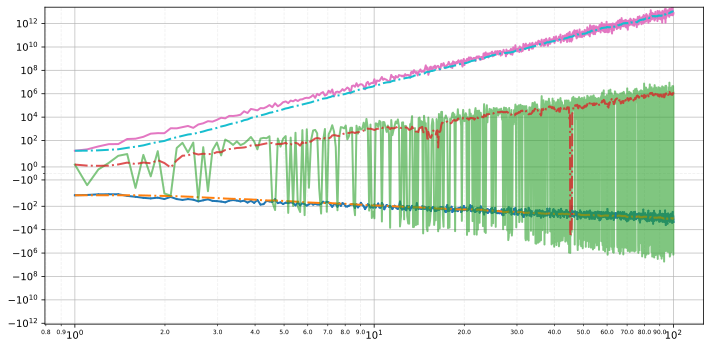

In [10]:
set_matplotlib_formats('pdf', 'svg')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

cmap = plt.get_cmap('tab10')
ax.plot(
    xs[0], ys[0], label='Model 1', marker='o', markersize=1,
    linestyle='-', linewidth=2, alpha=1.0, color=cmap(0)
)
ax.plot(
    xs[0], ewma_vectorized(ys[0], alpha=0.05), label='Model 1 (ewma)',
    linestyle='-.', linewidth=2, alpha=1.0, color=cmap(1)
)
ax.plot(
    xs[1], ys[1], label='Model 2', 
    linestyle='-', linewidth=2, alpha=0.6, color=cmap(2)
)
ax.plot(
    xs[1], ewma_vectorized(ys[1], alpha=0.05), label='Model 2 (ewma)',
    linestyle='-.', linewidth=2, alpha=0.8, color=cmap(3)
)
ax.plot(
    xs[2], ys[2], label='Model 3',
    linestyle='-', linewidth=2, alpha=1.0, color=cmap(6)
)
ax.plot(
    xs[2], ewma_vectorized(ys[2], alpha=0.05), label='Model 3 (ewma)',
    linestyle='-.', linewidth=2, alpha=1.0, color=cmap(9)
)
ax.grid(which='major', alpha=0.8)
ax.grid(which='minor', alpha=0.2, linestyle='--')
ax.set_xscale('log')
ax.set_yscale('symlog')

yticks = np.concatenate([-np.power(10, -np.arange(-12, 1.)), [0], np.power(10, np.arange(0, 13.))])
yticklabels = (
    ['$-10^{' + f'{idx}' + '}$' for idx in -np.arange(-12, 1)] + 
    [''] + 
    ['$10^{' + f'{idx}' + '}$' for idx in np.arange(0, 13)]
)
ax.set_yticks(yticks[::2])
ax.set_yticklabels(yticklabels[::2])

ax.xaxis.set_minor_formatter(ticker.FormatStrFormatter("%.1f"))
ax.tick_params(axis='both', which='minor', labelsize=6)

fig.tight_layout()
plt.show()
fig.savefig('./Figures/bad_plots/no_labels_plot.pdf')

# Не оптимальные стили линий

C:\Users\nahod\AppData\Local\Temp/ipykernel_22300/990059709.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


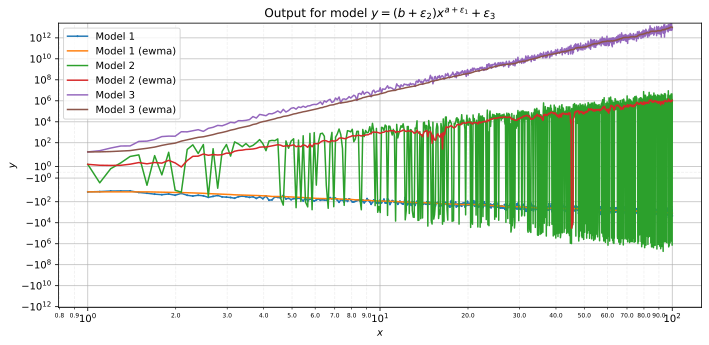

In [11]:
set_matplotlib_formats('pdf', 'svg')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(
    xs[0], ys[0], label='Model 1', marker='o', markersize=1,
)
ax.plot(
    xs[0], ewma_vectorized(ys[0], alpha=0.05), label='Model 1 (ewma)',
)
ax.plot(
    xs[1], ys[1], label='Model 2', 
)
ax.plot(
    xs[1], ewma_vectorized(ys[1], alpha=0.05), label='Model 2 (ewma)',
)
ax.plot(
    xs[2], ys[2], label='Model 3',
)
ax.plot(
    xs[2], ewma_vectorized(ys[2], alpha=0.05), label='Model 3 (ewma)',
)
ax.grid(which='major', alpha=0.8)
ax.grid(which='minor', alpha=0.2, linestyle='--')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('symlog')


yticks = np.concatenate([-np.power(10, -np.arange(-12, 1.)), [0], np.power(10, np.arange(0, 13.))])
yticklabels = (
    ['$-10^{' + f'{idx}' + '}$' for idx in -np.arange(-12, 1)] + 
    [''] + 
    ['$10^{' + f'{idx}' + '}$' for idx in np.arange(0, 13)]
)
ax.set_yticks(yticks[::2])
ax.set_yticklabels(yticklabels[::2])

ax.xaxis.set_minor_formatter(ticker.FormatStrFormatter("%.1f"))
ax.tick_params(axis='both', which='minor', labelsize=6)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Output for model $y = (b + \epsilon_{2})x^{a + \epsilon_{1}} + \epsilon_{3}$')

fig.tight_layout()
plt.show()
fig.savefig('./Figures/bad_plots/non_optimal_style_plot.pdf')

# Неудачные масштабы по осям

C:\Users\nahod\AppData\Local\Temp/ipykernel_22300/2973869860.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


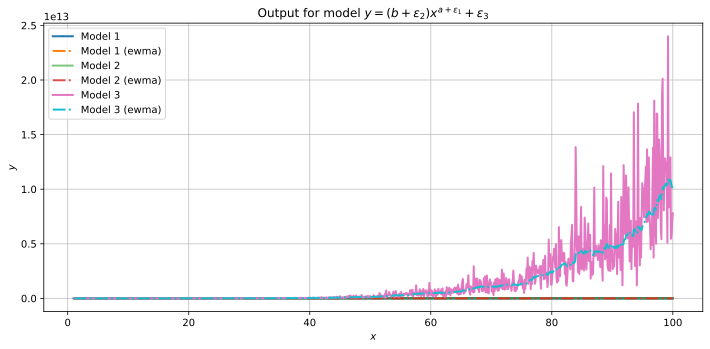

In [12]:
set_matplotlib_formats('pdf', 'svg')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

cmap = plt.get_cmap('tab10')
ax.plot(
    xs[0], ys[0], label='Model 1', marker='o', markersize=1,
    linestyle='-', linewidth=2, alpha=1.0, color=cmap(0)
)
ax.plot(
    xs[0], ewma_vectorized(ys[0], alpha=0.05), label='Model 1 (ewma)',
    linestyle='-.', linewidth=2, alpha=1.0, color=cmap(1)
)
ax.plot(
    xs[1], ys[1], label='Model 2', 
    linestyle='-', linewidth=2, alpha=0.6, color=cmap(2)
)
ax.plot(
    xs[1], ewma_vectorized(ys[1], alpha=0.05), label='Model 2 (ewma)',
    linestyle='-.', linewidth=2, alpha=0.8, color=cmap(3)
)
ax.plot(
    xs[2], ys[2], label='Model 3',
    linestyle='-', linewidth=2, alpha=1.0, color=cmap(6)
)
ax.plot(
    xs[2], ewma_vectorized(ys[2], alpha=0.05), label='Model 3 (ewma)',
    linestyle='-.', linewidth=2, alpha=1.0, color=cmap(9)
)
ax.grid(which='major', alpha=0.8)
ax.grid(which='minor', alpha=0.2, linestyle='--')
ax.legend()

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Output for model $y = (b + \epsilon_{2})x^{a + \epsilon_{1}} + \epsilon_{3}$')

fig.tight_layout()
plt.show()
fig.savefig('./Figures/bad_plots/no_scaling_plot.pdf')

# Не используется LaTeX

C:\Users\nahod\AppData\Local\Temp/ipykernel_22300/2332961526.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


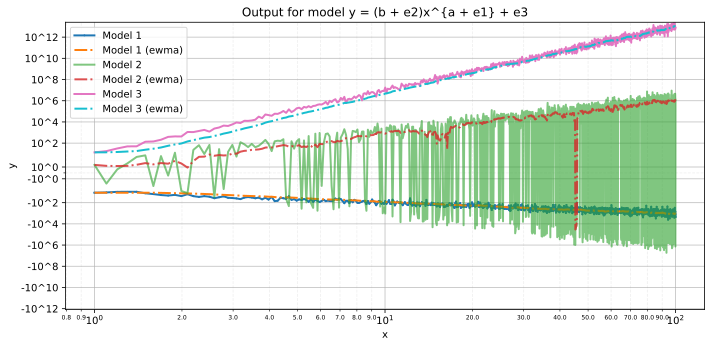

In [13]:
set_matplotlib_formats('pdf', 'svg')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

cmap = plt.get_cmap('tab10')
ax.plot(
    xs[0], ys[0], label='Model 1', marker='o', markersize=1,
    linestyle='-', linewidth=2, alpha=1.0, color=cmap(0)
)
ax.plot(
    xs[0], ewma_vectorized(ys[0], alpha=0.05), label='Model 1 (ewma)',
    linestyle='-.', linewidth=2, alpha=1.0, color=cmap(1)
)
ax.plot(
    xs[1], ys[1], label='Model 2', 
    linestyle='-', linewidth=2, alpha=0.6, color=cmap(2)
)
ax.plot(
    xs[1], ewma_vectorized(ys[1], alpha=0.05), label='Model 2 (ewma)',
    linestyle='-.', linewidth=2, alpha=0.8, color=cmap(3)
)
ax.plot(
    xs[2], ys[2], label='Model 3',
    linestyle='-', linewidth=2, alpha=1.0, color=cmap(6)
)
ax.plot(
    xs[2], ewma_vectorized(ys[2], alpha=0.05), label='Model 3 (ewma)',
    linestyle='-.', linewidth=2, alpha=1.0, color=cmap(9)
)
ax.grid(which='major', alpha=0.8)
ax.grid(which='minor', alpha=0.2, linestyle='--')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('symlog')

yticks = np.concatenate([-np.power(10, -np.arange(-12, 1.)), [0], np.power(10, np.arange(0, 13.))])
yticklabels = (
    ['-10^' + f'{idx}' + '' for idx in -np.arange(-12, 1)] + 
    [''] + 
    ['10^' + f'{idx}' + '' for idx in np.arange(0, 13)]
)
ax.set_yticks(yticks[::2])
ax.set_yticklabels(yticklabels[::2])

ax.xaxis.set_minor_formatter(ticker.FormatStrFormatter("%.1f"))
ax.tick_params(axis='both', which='minor', labelsize=6)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Output for model y = (b + e2)x^{a + e1} + e3')

fig.tight_layout()
plt.show()
fig.savefig('./Figures/bad_plots/no_latex_plot.pdf')

# Неоптимальный размер графика

C:\Users\nahod\AppData\Local\Temp/ipykernel_22300/2770044558.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


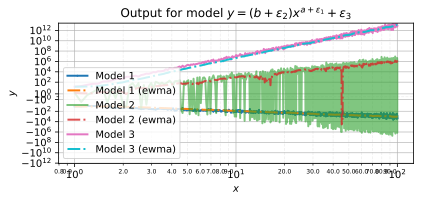

In [14]:
set_matplotlib_formats('pdf', 'svg')

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

cmap = plt.get_cmap('tab10')
ax.plot(
    xs[0], ys[0], label='Model 1', marker='o', markersize=1,
    linestyle='-', linewidth=2, alpha=1.0, color=cmap(0)
)
ax.plot(
    xs[0], ewma_vectorized(ys[0], alpha=0.05), label='Model 1 (ewma)',
    linestyle='-.', linewidth=2, alpha=1.0, color=cmap(1)
)
ax.plot(
    xs[1], ys[1], label='Model 2', 
    linestyle='-', linewidth=2, alpha=0.6, color=cmap(2)
)
ax.plot(
    xs[1], ewma_vectorized(ys[1], alpha=0.05), label='Model 2 (ewma)', 
    linestyle='-.', linewidth=2, alpha=0.8, color=cmap(3)
)
ax.plot(
    xs[2], ys[2], label='Model 3',
    linestyle='-', linewidth=2, alpha=1.0, color=cmap(6)
)
ax.plot(
    xs[2], ewma_vectorized(ys[2], alpha=0.05), label='Model 3 (ewma)',
    linestyle='-.', linewidth=2, alpha=1.0, color=cmap(9)
)
ax.grid(which='major', alpha=0.8)
ax.grid(which='minor', alpha=0.2, linestyle='--')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('symlog')


yticks = np.concatenate([-np.power(10, -np.arange(-12, 1.)), [0], np.power(10, np.arange(0, 13.))])
yticklabels = (
    ['$-10^{' + f'{idx}' + '}$' for idx in -np.arange(-12, 1)] + 
    [''] + 
    ['$10^{' + f'{idx}' + '}$' for idx in np.arange(0, 13)]
)
ax.set_yticks(yticks[::2])
ax.set_yticklabels(yticklabels[::2])

ax.xaxis.set_minor_formatter(ticker.FormatStrFormatter("%.1f"))
ax.tick_params(axis='both', which='minor', labelsize=6)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Output for model $y = (b + \epsilon_{2})x^{a + \epsilon_{1}} + \epsilon_{3}$')

fig.tight_layout()
plt.show()
fig.savefig('./Figures/bad_plots/no_resize_plot.pdf')